In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
#from clickhouse_driver.client import Client
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


%matplotlib inline

In [55]:
data = "datasets/transactions.csv"
df = pd.read_csv(data, parse_dates=True)
df.head(10)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [62]:

fb = pd.DataFrame(df)
 #, 'транзакции'
fb = fb.loc[fb['store_nbr'] == 1]
fb = fb[['date', 'transactions']] 


In [63]:
fb

,date,transactions
1,2013-01-02,2111
47,2013-01-03,1833
93,2013-01-04,1863
139,2013-01-05,1509
185,2013-01-06,520
...,...,...
83218,2017-08-11,570
83272,2017-08-12,1004
83326,2017-08-13,416
83380,2017-08-14,1733


In [64]:
fb.index

Int64Index([    1,    47,    93,   139,   185,   231,   277,   323,   369,
              415,
            ...
            82948, 83002, 83056, 83110, 83164, 83218, 83272, 83326, 83380,
            83434],
           dtype='int64', length=1676)

In [66]:
fb.index = np.arange(len(fb))
fb

,date,transactions
0,2013-01-02,2111
1,2013-01-03,1833
2,2013-01-04,1863
3,2013-01-05,1509
4,2013-01-06,520
...,...,...
1671,2017-08-11,570
1672,2017-08-12,1004
1673,2017-08-13,416
1674,2017-08-14,1733


In [69]:
df = fb[0:363]
df

,date,transactions
0,2013-01-02,2111
1,2013-01-03,1833
2,2013-01-04,1863
3,2013-01-05,1509
4,2013-01-06,520
...,...,...
358,2013-12-27,2022
359,2013-12-28,1070
360,2013-12-29,416
361,2013-12-30,1388


In [70]:
df2 = fb[0:600]
df2

,date,transactions
0,2013-01-02,2111
1,2013-01-03,1833
2,2013-01-04,1863
3,2013-01-05,1509
4,2013-01-06,520
...,...,...
595,2014-08-22,1766
596,2014-08-23,1214
597,2014-08-24,494
598,2014-08-25,1789


In [150]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [219]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=14):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=12) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

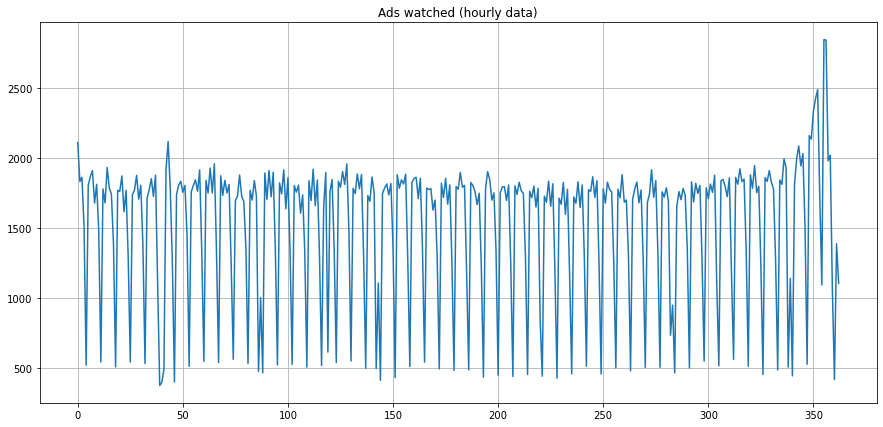

In [79]:
plt.figure(figsize=(15, 7))
plt.plot(df['transactions'])
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

In [96]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [220]:
%%time
data = df['transactions']#[:-50] # leave some data for testing
# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error), 
               method="TNC", bounds = ((0, 2), (0, 2), (0, 2))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)



0.0 0.001675829022590447 0.0139483863850417
Wall time: 18.1 s


In [251]:
model = HoltWinters(data, slen = 28, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)

model.triple_exponential_smoothing()

In [254]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    #print(sum(model.result[-31:]))
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(df2['transactions'], label = "Actual")
    error = mean_absolute_percentage_error(df2['transactions'][363:463], model.result[363:463])
    plt.title(" Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")
        
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

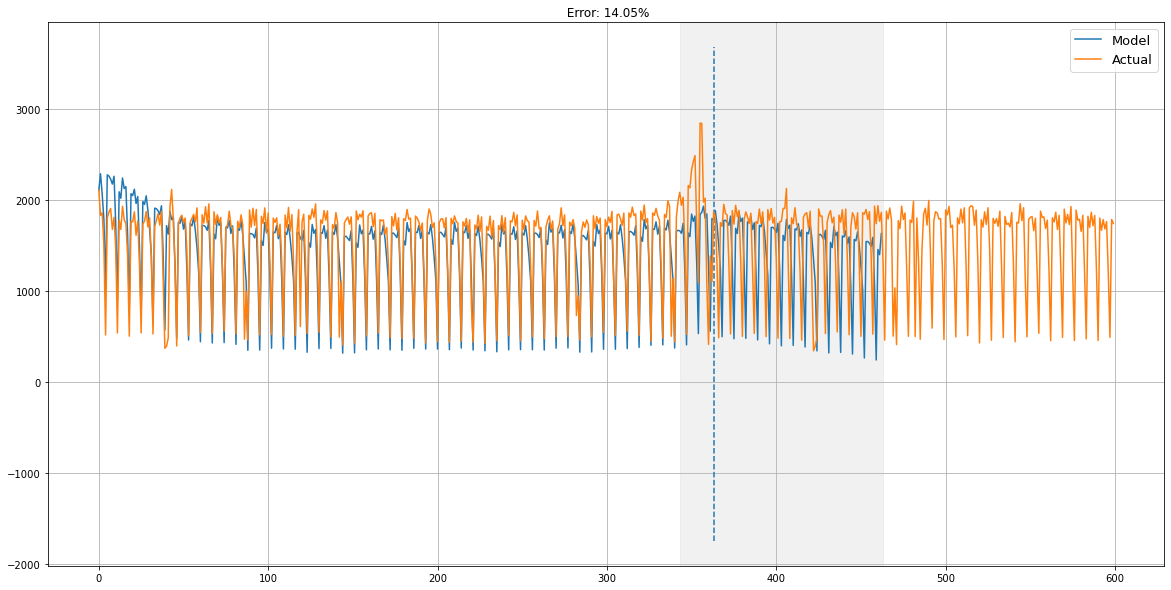

In [255]:
plotHoltWinters(data)

In [ ]:
#print("Fact")
#for i in df['GMV DR'][-85:]:
#    print(str(i).replace('.',','))
    
print("\n\n\nModel")
for i in model.result[-91:]:
    print(str(i).replace('.',','))